## Notebook de mise en place d'un CNN ##

Le CNN entraîné uniquement à partir du dataset fourni n'offre pas des performances suffisantes.  
Dans ce notebook, je vais donc faire appel à deux modèles déjà établis et entraînés sur des jeux de données massifs, via le Transfer Learning.

In [ ]:
# Projet
from src.scripts.train import cnn_handling
from src.scripts.data import feature_engineering
import importlib
importlib.reload(cnn_handling)
from config.paths import DATA_DIR

# Data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications.resnet50 import preprocess_input as preprocess_resnet
from tensorflow.keras.applications.vgg16 import preprocess_input as preprocess_vgg
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay



# Modélisation
import tensorflow
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.applications import ResNet50, VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

### Tests de modèles via Transfer Learning ###

#### Chargement et préparation des données ####

Pour le chargement et la préparation des données, la littérature recommande d'utiliser les images non transformées, et d'utiliser les fonctions de preprocessing propres aux deux modèles que je vais utiliser: VGG16 et ResNet50.

In [7]:
data = pd.read_json(f'{DATA_DIR}/silver/image_metadata.json')

In [8]:
image_arrays = np.load(f'{DATA_DIR}/silver/image_arrays.npy')

array([[[183, 202, 209],
        [181, 199, 206],
        [177, 194, 201],
        ...,
        [129, 127, 128],
        [128, 126, 127],
        [127, 125, 126]],

       [[175, 193, 200],
        [174, 191, 198],
        [173, 190, 197],
        ...,
        [128, 126, 127],
        [127, 125, 126],
        [126, 124, 125]],

       [[187, 203, 210],
        [187, 202, 209],
        [184, 199, 206],
        ...,
        [128, 126, 127],
        [128, 126, 127],
        [128, 126, 127]],

       ...,

       [[127, 127, 127],
        [128, 128, 128],
        [130, 130, 130],
        ...,
        [114, 114, 114],
        [112, 112, 112],
        [107, 107, 107]],

       [[132, 132, 132],
        [136, 136, 136],
        [138, 138, 138],
        ...,
        [113, 113, 113],
        [110, 110, 110],
        [103, 103, 103]],

       [[127, 127, 127],
        [131, 131, 131],
        [132, 132, 132],
        ...,
        [108, 108, 108],
        [107, 107, 107],
        [100, 100, 100]]], dtype=uint8)
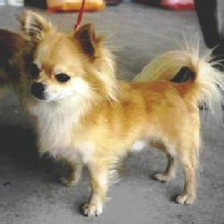

In [9]:
image_arrays[0]

In [10]:
X = image_arrays
y = data.race.values

Les classes doivent d'abord être encodées pour pouvoir être apprises et prédites par les CNN.

In [11]:
num_classes = len(data.race.unique())
y, class_names = feature_engineering.encode_dog_races(y, num_classes)

In [12]:
class_names

array(['Chihuahua', 'Japanese spaniel', 'Maltese dog', 'Pekinese',
       'Shih-Tzu'], dtype=object)

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2, random_state=42)

In [14]:
print(y_train.shape, y_test.shape)

(761, 5) (191, 5)


Les modèles de Transfer Learning comme Resnet et Vgg s'attendent à un format d'image spécifique.  
J'applique donc un prétraitement adapté.

In [26]:
X_train_resnet = preprocess_resnet(X_train)
X_test_resnet = preprocess_resnet(X_test)

X_train_vgg = preprocess_vgg(X_train)
X_test_vgg = preprocess_vgg(X_test)

#### Test de VGG ####

VGG est un CNN pré-entraîné sur les données massives de la base d'images ImageNet.  
L'utiliser me permet donc de bénéficier de ses couches déjà entraînées, que je gèle, tout en ajoutant des couches denses en sortie qui vont apprendre de mes données.

In [24]:
base_model_vgg = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model_vgg.trainable = False

x = GlobalAveragePooling2D()(base_model_vgg.output)
x = Dense(256, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)

model_vgg = Model(inputs=base_model_vgg.input, outputs=predictions)

optimizer = tensorflow.keras.optimizers.Adam(learning_rate=1e-5)
model_vgg.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

58889256/58889256 [==============================] - 0s 0us/step


In [29]:
history_vgg = model_vgg.fit(
    X_train_vgg, y_train,
    validation_data=(X_test_vgg, y_test),
    epochs=10,
    batch_size=32
)

Epoch 1/10
24/24 [==============================] - 17s 722ms/step - loss: 1.0530 - accuracy: 0.6833 - val_loss: 1.3113 - val_accuracy: 0.6597
Epoch 2/10
24/24 [==============================] - 17s 702ms/step - loss: 0.9984 - accuracy: 0.6938 - val_loss: 1.2700 - val_accuracy: 0.6754
Epoch 3/10
24/24 [==============================] - 17s 703ms/step - loss: 0.9488 - accuracy: 0.7043 - val_loss: 1.2312 - val_accuracy: 0.6754
Epoch 4/10
24/24 [==============================] - 17s 703ms/step - loss: 0.9042 - accuracy: 0.7148 - val_loss: 1.1971 - val_accuracy: 0.6806
Epoch 5/10
24/24 [==============================] - 16s 693ms/step - loss: 0.8629 - accuracy: 0.7293 - val_loss: 1.1666 - val_accuracy: 0.6806
Epoch 6/10
24/24 [==============================] - 17s 695ms/step - loss: 0.8258 - accuracy: 0.7411 - val_loss: 1.1385 - val_accuracy: 0.6806
Epoch 7/10
24/24 [==============================] - 16s 688ms/step - loss: 0.7882 - accuracy: 0.7582 - val_loss: 1.1110 - val_accuracy: 0.6806

In [ ]:
preds_train_vgg = model_vgg.predict(X_train_vgg)
preds_test_vgg = model_vgg.predict(X_test_vgg)
labels_train_vgg = np.argmax(preds_train_vgg, axis=1)
labels_test_vgg = np.argmax(preds_test_vgg, axis=1)

unique, counts = np.unique(labels_train_vgg, return_counts=True)
print(dict(zip(unique, counts)))

cm_vgg = confusion_matrix(np.argmax(y_test, axis=1), labels_test_vgg)
ConfusionMatrixDisplay(cm_vgg).plot()

VGG offre des performances bien plus intéressantes que le CNN maison.

#### Test de Resnet ####

ResNet est un autre CNN pré-entraîné à partir d'ImageNet, qui offre une architecture novatrice basée sur le transfert résiduel de l'apprentissage entre les couches du réseau, ce qui permet une meilleure rétention de l'information et de meilleures performances.  
J'applique la même méthodologie que pour VGG.

In [16]:
base_model_resnet = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model_resnet.trainable = False

x = GlobalAveragePooling2D()(base_model_resnet.output)
x = Dense(256, activation='relu')(x)
predictions = Dense(5, activation='softmax')(x)

model_resnet = Model(inputs=base_model_resnet.input, outputs=predictions)

94765736/94765736 [==============================] - 0s 0us/step


In [17]:
model_resnet.compile(optimizer='adam',
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])


In [18]:
optimizer = tensorflow.keras.optimizers.Adam(learning_rate=1e-5)
model_resnet.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [19]:
history_resnet = model_resnet.fit(
    X_train_resnet, y_train,
    validation_data=(X_test_resnet, y_test),
    epochs=10,
    batch_size=32
)

Epoch 1/10
24/24 [==============================] - 20s 695ms/step - loss: 1.5319 - accuracy: 0.3535 - val_loss: 1.4383 - val_accuracy: 0.3979
Epoch 2/10
24/24 [==============================] - 15s 650ms/step - loss: 1.2892 - accuracy: 0.4941 - val_loss: 1.2533 - val_accuracy: 0.4974
Epoch 3/10
24/24 [==============================] - 15s 643ms/step - loss: 1.1096 - accuracy: 0.6058 - val_loss: 1.0928 - val_accuracy: 0.6283
Epoch 4/10
24/24 [==============================] - 16s 651ms/step - loss: 0.9643 - accuracy: 0.6925 - val_loss: 0.9675 - val_accuracy: 0.6963
Epoch 5/10
24/24 [==============================] - 15s 651ms/step - loss: 0.8478 - accuracy: 0.7622 - val_loss: 0.8626 - val_accuracy: 0.7644
Epoch 6/10
24/24 [==============================] - 15s 634ms/step - loss: 0.7503 - accuracy: 0.8160 - val_loss: 0.7710 - val_accuracy: 0.8010
Epoch 7/10
24/24 [==============================] - 15s 646ms/step - loss: 0.6712 - accuracy: 0.8397 - val_loss: 0.6955 - val_accuracy: 0.8115

In [20]:
preds_train = model_resnet.predict(X_train_resnet)
preds_test = model_resnet.predict(X_test_resnet)
labels_train = np.argmax(preds_train, axis=1)
labels_test = np.argmax(preds_test, axis=1)


6/6 [==============================] - 3s 524ms/step


In [21]:
unique, counts = np.unique(labels_train, return_counts=True)
print(dict(zip(unique, counts)))

{0: 123, 1: 148, 2: 222, 3: 106, 4: 162}


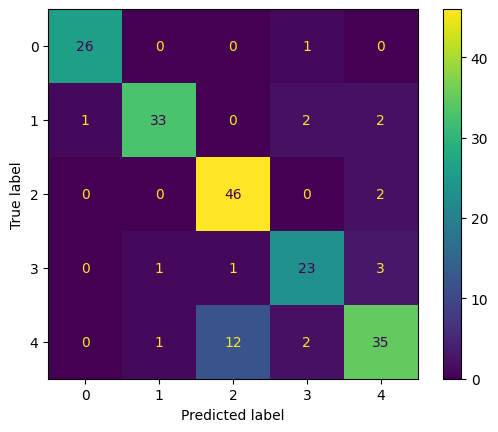

In [22]:
cm = confusion_matrix(np.argmax(y_test, axis=1), labels_test)
ConfusionMatrixDisplay(cm).plot()


ResNet offre de loin les meilleures performances parmi tous les modèles que j'ai pu tester jusqu'alors.  
Je choisis donc ce modèle pour l'intégrer dans mon dashboard de test de l'algorithme de classification.

In [ ]:
model_resnet.save("model_resnet_dog_breeds.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
